## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[all]`. 

In [1]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

     |████████████████████████████████| 212 kB 5.1 MB/s 
     |████████████████████████████████| 10.0 MB 45.5 MB/s 
     |████████████████████████████████| 2.2 MB 45.6 MB/s 
     |████████████████████████████████| 23.6 MB 49.5 MB/s 
     |████████████████████████████████| 1.3 MB 30.4 MB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 91 kB 7.7 MB/s 
     |████████████████████████████████| 35.4 MB 98 kB/s 
     |████████████████████████████████| 71.0 MB 466 kB/s 
     |████████████████████████████████| 98.5 MB 1.2 MB/s 
     |████████████████████████████████| 218.4 MB 43 kB/s 
     |████████████████████████████████| 1.3 MB 35.2 MB/s 
     |████████████████████████████████| 47.5 MB 1.8 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
     |████████████████████████████████| 160 kB 47.8 MB/s 
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |██████████████

Found existing installation: torchtext 0.11.0
Uninstalling torchtext-0.11.0:
  Successfully uninstalled torchtext-0.11.0


## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 5 simple steps.

## **Problem 1: Predict WindSpeed by Hour**


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.20.1

!pip uninstall pandas -y
!pip install pandas==1.2.2

In [1]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd

In [4]:
#Download TEST dataset
!git clone https://github.com/callmeJ274/Wind_time_series_Datasets.git

Cloning into 'Wind_time_series_Datasets'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [5]:
df_ = pd.read_csv('/content/Wind_time_series_Datasets/data_/Wind Time Series Dataset(hourly).csv') # We're gonna experiment this
df_[['Time']] = df_[['Time']].apply(pd.to_datetime)

### **Step 1: Init Orca Context** 

In [2]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [15]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-12-19 03:06:20,861	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-12-19_03-06-20_298549_369/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-12-19_03-06-20_298549_369/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-12-19_03-06-20_298549_369', 'metrics_export_port': 63415, 'node_id': '340c1139490d4d2a481cf5085049d061db6ad4e3b1b13241451039c2'}


<SparkContext master=local[4] appName=pyspark-shell>

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [27]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_, # the dataframe to load
                                                              dt_col="Time",  # the column name specifying datetime
                                                              target_col="WindSpeed", # the column name to predict
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(features = 'all')\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [28]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='lstm', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [29]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

2021-12-19 03:09:34,060	INFO tune.py:450 -- Total run time: 42.74 seconds (42.65 seconds for the tuning loop).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06282302243187625 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [30]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [31]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 0.9096527810948979
Evaluate: the smape value is 0.10955937877966561


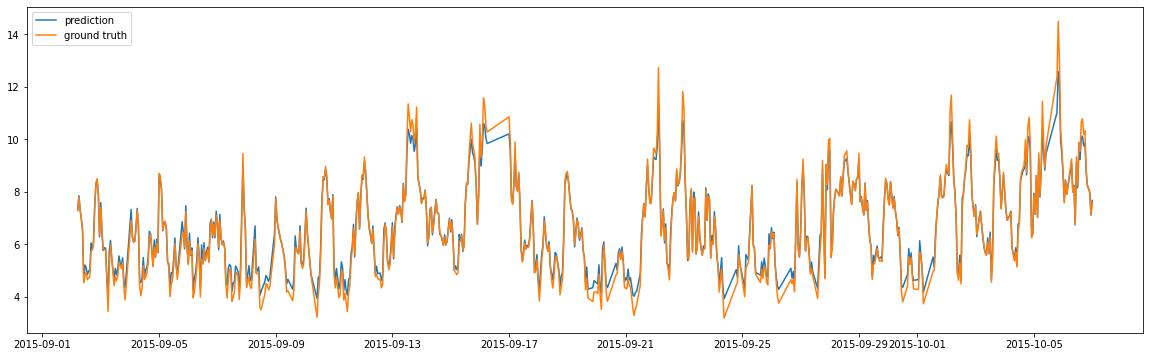

In [32]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(20,6))
plt.plot(groundtruth_unscale["Time"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["Time"], groundtruth_unscale[['WindSpeed']])
plt.legend(["prediction", "ground truth"])

In [33]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context


## **Problem 2: WindSpeed + Time -> Power**


### **Step 1: Init Orca Context** 

In [34]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [47]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar --driver-c

2021-12-19 03:16:47,518	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-12-19_03-16-46_848355_369/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-12-19_03-16-46_848355_369/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-12-19_03-16-46_848355_369', 'metrics_export_port': 61825, 'node_id': '85207ce2e06f920d65882cace5be88ecec6d779869cb9fa23aee467e'}


<SparkContext master=local[4] appName=pyspark-shell>

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

Appoint time features: MINUTE, HOUR, DAY, MONTH, YEAR: but when fitting, model only chose MINUTE, MONTH, YEAR???

In [55]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_, # the dataframe to load
                                                              dt_col="Time",  # the column name specifying datetime
                                                              target_col="Power", # the column name to predict
                                                              extra_feature_col = 'WindSpeed',
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(features = 'all')\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [56]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='lstm', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [57]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

2021-12-19 03:22:08,043	INFO tune.py:450 -- Total run time: 49.72 seconds (49.67 seconds for the tuning loop).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10828626518377467 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [58]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [59]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 140.687020563744
Evaluate: the smape value is 0.4228651113214508


In [53]:
# evaluate the result pipeline_OLD
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 141.75037982338822
Evaluate: the smape value is 0.44614050943516476


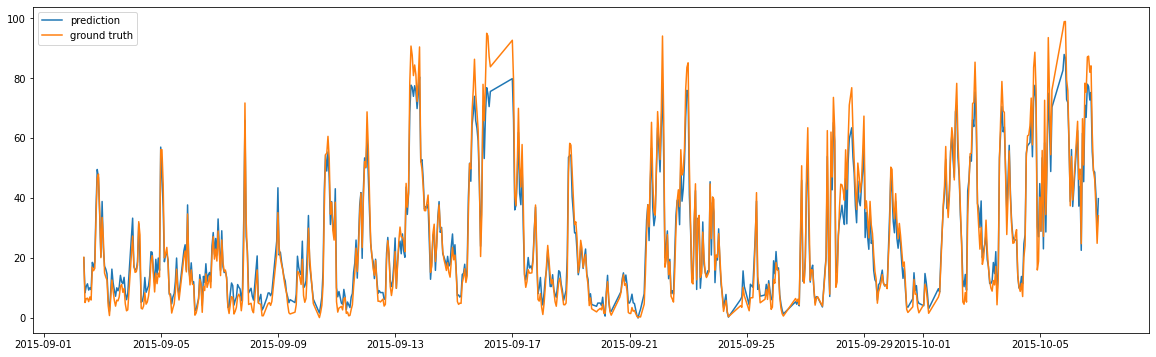

In [60]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(20,6))
plt.plot(groundtruth_unscale["Time"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["Time"], groundtruth_unscale[['Power']])
plt.legend(["prediction", "ground truth"])

In [61]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context
